In [1]:

import pandas as pd
import numpy as np
import sys
from sklearn.model_selection import train_test_split
import GPUtil
import itertools
import pickle
from datetime import datetime
import os
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch
import torch.nn as nn
from sklearn.preprocessing import Normalizer
import joblib
import ili  # Import ili for the SBI functionality
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior

from sbi.utils.user_input_checks import process_prior

sys.path.append("/disk/xray15/aem2/camels/proj2")
from setup_params_1P import plot_uvlf, plot_colour
from setup_params_SB import *
# from setup_params import *
from priors_SB import initialise_priors_SB28
from variables_config_28 import uvlf_limits, n_bins_lf, colour_limits, n_bins_colour
# parameters
device = "cuda" if torch.cuda.is_available() else "cpu"
model = "IllustrisTNG"
spec_type = "attenuated"
sps = "BC03"
snap = ["044"]
bands = "all" # or just GALEX?

colours = False  
luminosity_functions = True
name = f"{model}_{bands}_{sps}_{spec_type}_{n_bins_lf}_{n_bins_colour}"

cam = camels(model=model, sim_set='SB28')

if colours and not luminosity_functions:
    model_out_dir = "/disk/xray15/aem2/data/28pams/IllustrisTNG/SB/models/colours_only/"
    plots_out_dir = "/disk/xray15/aem2/plots/28pams/IllustrisTNG/SB/test/sbi_plots/colours_only/"
    
elif luminosity_functions and not colours:
    model_out_dir = "/disk/xray15/aem2/data/28pams/IllustrisTNG/SB/models/lf_only/"
    plots_out_dir = "/disk/xray15/aem2/plots/28pams/IllustrisTNG/SB/test/sbi_plots/lfs_only/"

elif colours and luminosity_functions:
    model_out_dir = "/disk/xray15/aem2/data/28pams/IllustrisTNG/SB/models/colours_lfs/"
    plots_out_dir = "/disk/xray15/aem2/plots/28pams/IllustrisTNG/SB/test/sbi_plots/colours_lfs/"

else:
    raise ValueError("At least one of colours or luminosity_functions must be True")

print("Saving model in ", model_out_dir)
print("Saving plots in ", plots_out_dir)



Saving model in  /disk/xray15/aem2/data/28pams/IllustrisTNG/SB/models/lf_only/
Saving plots in  /disk/xray15/aem2/plots/28pams/IllustrisTNG/SB/test/sbi_plots/lfs_only/


In [2]:
# First, let's check what type of data we have
def convert_to_numpy(data):
    """
    Safely converts data to numpy array regardless of whether it's a torch tensor or numpy array
    
    Parameters:
        data: Input data (either torch.Tensor or numpy.ndarray)
    
    Returns:
        numpy.ndarray: The data converted to numpy array
    """
    if torch.is_tensor(data):
        # If it's a torch tensor, move to CPU and convert to numpy
        return data.cpu().numpy()
    elif isinstance(data, np.ndarray):
        # If it's already a numpy array, return as is
        return data
    else:
        # If it's neither, try converting to numpy array
        return np.array(data)


In [3]:
print(uvlf_limits)

(-25, -14)


In [4]:

# parameter info file (df_info) is used for defining priors
# the actual parameter values come from the camels class which reads CosmoAstroSeed_IllustrisTNG_L25n256_SB28.txt

#  parameters defined here: /disk/xray15/aem2/data/28pams/IllustrisTNG/SB/CosmoAstroSeed_IllustrisTNG_L25n256_SB28.txt which is used for theta
df_pars = pd.read_csv('/disk/xray15/aem2/data/28pams/IllustrisTNG/SB/CosmoAstroSeed_IllustrisTNG_L25n256_SB28.txt', delim_whitespace=True)
print(df_pars)


          #Name    Omega0    sigma8  WindEnergyIn1e51erg  RadioFeedbackFactor  \
0        SB28_0  0.352541  0.694742              3.85743             1.519210   
1        SB28_1  0.172430  0.830154              1.03554             0.797734   
2        SB28_2  0.234683  0.705844              9.61416             3.380650   
3        SB28_3  0.440288  0.969259              2.14363             0.488165   
4        SB28_4  0.457152  0.786733              1.38466             0.325727   
...         ...       ...       ...                  ...                  ...   
2043  SB28_2043  0.457334  0.970226              8.89733             0.607197   
2044  SB28_2044  0.440496  0.786137              5.34131             0.880840   
2045  SB28_2045  0.234475  0.938760              1.49723             1.873430   
2046  SB28_2046  0.172613  0.612888             13.31250             0.363806   
2047  SB28_2047  0.352358  0.862216              3.09935             3.331570   

      VariableWindVelFactor

In [5]:
df_pars

,#Name,Omega0,sigma8,WindEnergyIn1e51erg,RadioFeedbackFactor,VariableWindVelFactor,RadioFeedbackReiorientationFactor,OmegaBaryon,HubbleParam,n_s,...,WindEnergyReductionExponent,WindDumpFactor,SeedBlackHoleMass,BlackHoleAccretionFactor,BlackHoleEddingtonFactor,BlackHoleFeedbackFactor,BlackHoleRadiativeEfficiency,QuasarThreshold,QuasarThresholdPower,seed
0,SB28_0,0.352541,0.694742,3.85743,1.519210,9.09267,14.2845,0.049404,0.498145,0.795765,...,1.61148,0.435971,0.000069,1.111740,2.613460,0.039463,0.225386,0.000269,0.514648,20000
1,SB28_1,0.172430,0.830154,1.03554,0.797734,6.95693,38.2374,0.031199,0.683693,1.142160,...,2.08951,0.612056,0.000094,0.889955,0.302262,0.151352,0.086231,0.022802,2.620780,20001
2,SB28_2,0.234683,0.705844,9.61416,3.380650,3.77681,24.6592,0.042995,0.849506,0.923545,...,1.33988,0.878906,0.000153,0.364219,8.235920,0.099772,0.648096,0.001458,3.389560,20002
3,SB28_3,0.440288,0.969259,2.14363,0.488165,11.49660,10.9550,0.062295,0.638970,0.964648,...,2.86478,0.253435,0.000041,2.775960,0.950425,0.349945,0.126670,0.004242,1.494400,20003
4,SB28_4,0.457152,0.786733,1.38466,0.325727,13.19410,17.1439,0.044425,0.773770,0.900256,...,2.59030,0.944457,0.000049,0.286789,1.121900,0.032352,0.460414,0.007438,2.299550,20004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2043,SB28_2043,0.457334,0.970226,8.89733,0.607197,3.75653,39.5139,0.046041,0.513293,0.828903,...,1.88784,0.725070,0.000054,0.327481,4.790910,0.033553,0.481742,0.001252,2.191720,22043
2044,SB28_2044,0.440496,0.786137,5.34131,0.880840,5.04789,21.6844,0.063161,0.748997,1.143290,...,1.66098,0.472330,0.000038,2.229260,0.222157,0.397001,0.109068,0.000416,1.012360,22044
2045,SB28_2045,0.234475,0.938760,1.49723,1.873430,13.26680,13.5869,0.042461,0.534548,0.796116,...,2.13803,0.698393,0.000174,0.453541,1.920250,0.087029,0.682619,0.006263,3.117210,22045
2046,SB28_2046,0.172613,0.612888,13.31250,0.363806,8.64069,17.7159,0.029257,0.600362,0.965127,...,1.38572,0.818457,0.000090,0.718570,0.698528,0.158683,0.083655,0.000071,2.887940,22046


In [6]:
no_pams = 6
end_of_pams = no_pams + 1 
param_names = df_pars.columns[1:end_of_pams].tolist()  # Excluding 'name' column
param_length = len(param_names)


param_length


6

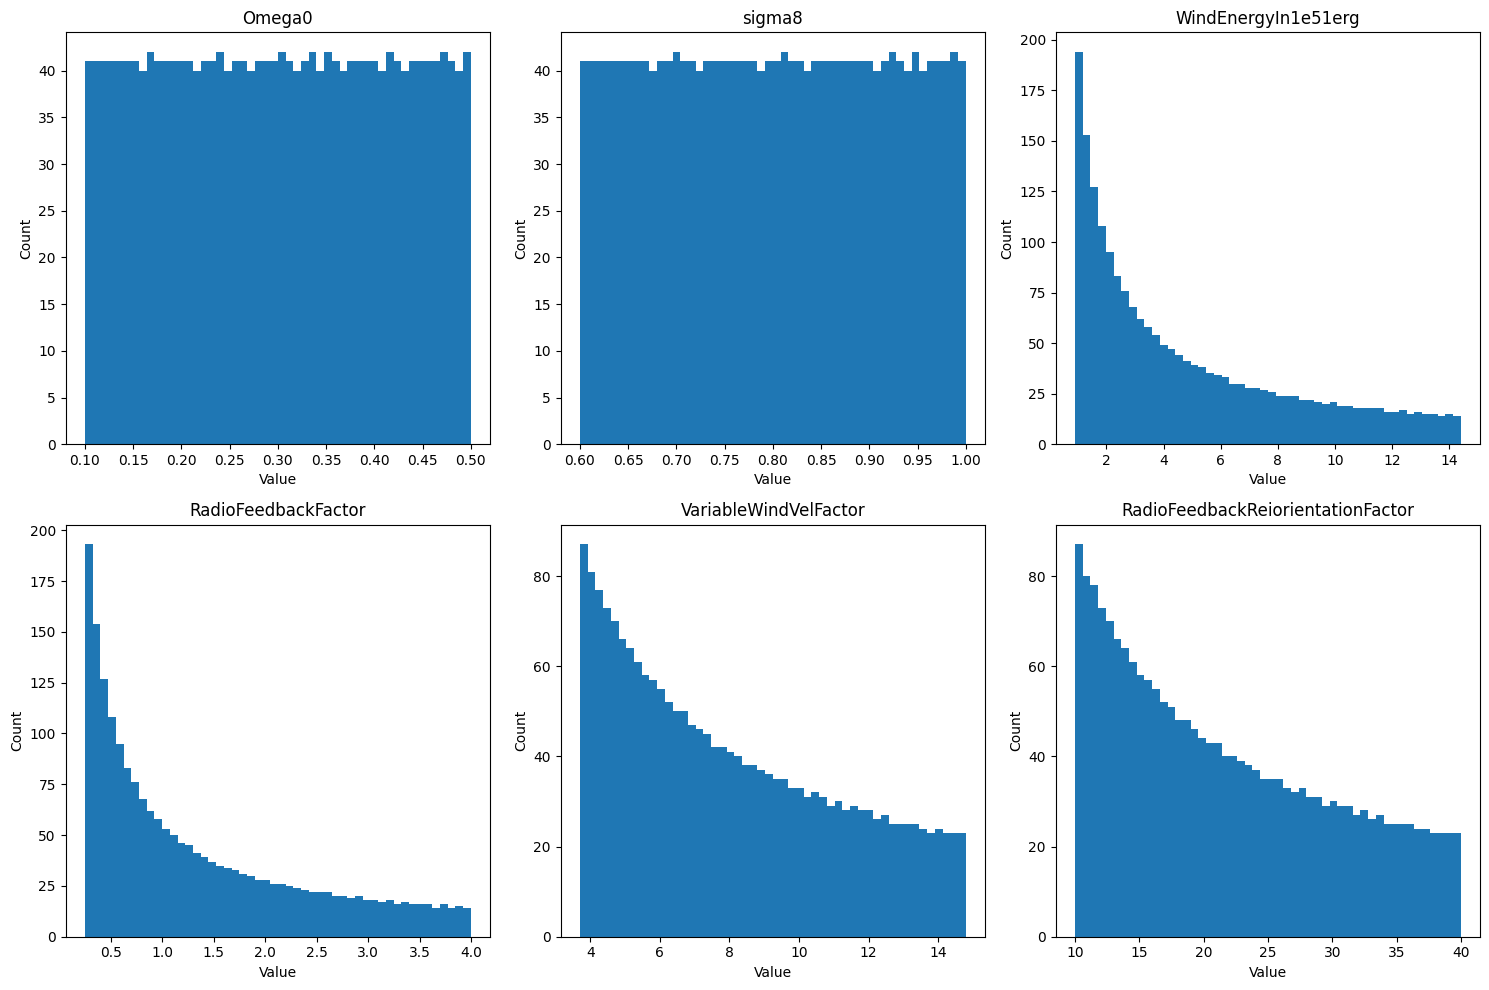

In [7]:
theta_lst = df_pars.iloc[:, 1:end_of_pams].to_numpy()  # excluding 'name' column and 'seed' column

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, param_name in enumerate(param_names):
    axes[i].hist(theta_lst[:, i], bins=50)
    axes[i].set_title(param_name)
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Count')

plt.tight_layout()
plt.show()


In [8]:


# prior values come from this:
df_info = pd.read_csv("/disk/xray15/aem2/data/28pams/Info_IllustrisTNG_L25n256_28params.txt")
print(df_info)


                            ParamName  AbsMaxDiff  LogFlag  FiducialVal  \
0                              Omega0        0.20        0      0.30000   
1                              sigma8        0.20        0      0.80000   
2                 WindEnergyIn1e51erg        4.00        1      3.60000   
3                 RadioFeedbackFactor        4.00        1      1.00000   
4               VariableWindVelFactor        2.00        1      7.40000   
5   RadioFeedbackReiorientationFactor        2.00        1     20.00000   
6                         OmegaBaryon        0.02        0      0.04900   
7                         HubbleParam        0.20        0      0.67110   
8                                 n_s        0.20        0      0.96240   
9                     MaxSfrTimescale        2.00        1      2.27000   
10                 FactorForSofterEQS        3.00        1      0.30000   
11                           IMFslope        0.50        0     -2.30000   
12                  SNII_

In [9]:
df_info6 = df_info[0:6]
df_info6

,ParamName,AbsMaxDiff,LogFlag,FiducialVal,MinVal,MaxVal,Description
0,Omega0,0.2,0,0.3,0.10,0.5,OmegaMatter
1,sigma8,0.2,0,0.8,0.60,1.0,sigma8
2,WindEnergyIn1e51erg,4.0,1,3.6,0.90,14.4,ASN1 - galactic winds energy
3,RadioFeedbackFactor,4.0,1,1.0,0.25,4.0,AAGN1 - AGN FB kinetic mode energy
4,VariableWindVelFactor,2.0,1,7.4,3.70,14.8,ASN2 - galactic winds speed
5,RadioFeedbackReiorientationFactor,2.0,1,20.0,10.00,40.0,AAGN2 - AGN FB kinetic mode burstiness


In [10]:
# overwrite theta with the real theta
if __name__ == "__main__":
    theta, x = get_theta_x_SB(
        luminosity_functions=luminosity_functions,
        colours=colours,
        uvlf_limits=uvlf_limits,
        colour_limits=colour_limits,
        n_bins_lf=n_bins_lf,
        n_bins_colour=n_bins_colour
    )
    print(theta.shape, x.shape)
    

torch.Size([2048, 28]) (2048, 24)


In [11]:
# convert to numpy
x = convert_to_numpy(x)
theta = convert_to_numpy(theta)

print("Type of x:", type(x))
print("Type of theta:", type(theta))

Type of x: <class 'numpy.ndarray'>
Type of theta: <class 'numpy.ndarray'>


In [12]:

# get the priors and data
prior = initialise_priors_SB28(
    df=df_info6, 
    device=device,
    astro=True,
    dust=False  # no dust for testing. set to False to only get the 28 model parameters.
    # with dust = True, prior has 32 dimensions (28 parameters + 4 dust parameters) 
)


processing Omega0:
processing Omega0 is linear with min 0.1 and max 0.5:
processing sigma8:
processing sigma8 is linear with min 0.6 and max 1.0:
processing WindEnergyIn1e51erg:
processing WindEnergyIn1e51erg is logarithmic with min 0.9 and max 14.4:
processing RadioFeedbackFactor:
processing RadioFeedbackFactor is logarithmic with min 0.25 and max 4.0:
processing VariableWindVelFactor:
processing VariableWindVelFactor is logarithmic with min 3.7 and max 14.8:
processing RadioFeedbackReiorientationFactor:
processing RadioFeedbackReiorientationFactor is logarithmic with min 10.0 and max 40.0:


/disk/xray15/aem2/envs/camels/lib/python3.8/site-packages/sbi/utils/user_input_checks.py:76: UserWarning: Prior was provided as a sequence of 6 priors. They will be
            interpreted as independent of each other and matched in order to the
            components of the parameter.
  warnings.warn(
/disk/xray15/aem2/envs/camels/lib/python3.8/site-packages/sbi/utils/torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect no significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(
/disk/xray15/aem2/envs/camels/lib/python3.8/site-packages/sbi/utils/user_input_checks.py:209: UserWarning: Casting 1D Uniform prior to BoxUniform to match sbi batch requirements.
  warnings.warn(


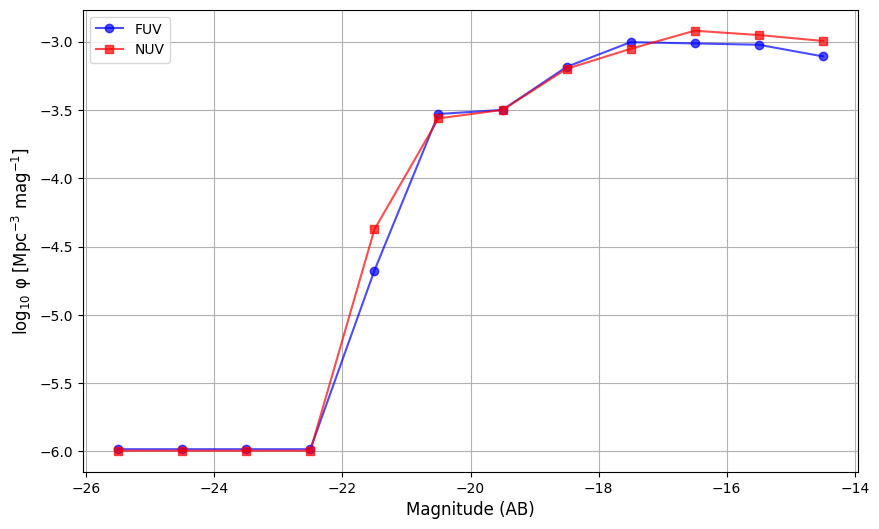

In [13]:
if colours:
    fig = plot_colour(x)
    plt.savefig('/disk/xray15/aem2/plots/28pams/IllustrisTNG/SB/test/colours_test/colour_check.png')
    plt.show()

if luminosity_functions:
    fig = plot_uvlf(x)
    plt.savefig('/disk/xray15/aem2/plots/28pams/IllustrisTNG/SB/test/LFs_test/uvlf_check.png')
    plt.show()



If using only luminosity functions (LFs):

2 GALEX filters (FUV, NUV)
Each filter gets n_bins_lf (12) bins
2 filters * 12 bins = 24 features

If also using colors:

1 color (FUV-NUV)
Gets n_bins_colour (12) bins
Total would be 24 + 12 = 36 features

In [14]:

# process the data
# x_all = np.array([np.hstack(_x) for _x in x])

print("Theta shape:", theta.shape)
print("X shape:", x.shape)


Theta shape: (2048, 28)
X shape: (2048, 24)


In [15]:

# Handle NaN values and normalize while on GPU
# print('x_all_cpu:', x_all_cpu)

# print("Data shape before processing:", x_all_cpu.shape)
# print("Number of values:",(x_all_cpu).sum())
# print("Number of NaN values:", np.isnan(x_all_cpu).sum())
# print("Number of infinite values:", np.isinf(x_all_cpu).sum())


# get rid of NaN/inf values, replace with small random noise
# nan_mask = np.isnan(x_all_cpu) | np.isinf(x_all_cpu)
# print('nan_mask:', nan_mask)


# if nan_mask.any():
#     x_all_cpu[nan_mask] = np.random.rand(np.sum(nan_mask)) * 1e-10

print("Data shape before processing:", x.shape)
print("Number of NaN values:", np.isnan(x).sum())
print("Number of infinite values:", np.isinf(x).sum())



# # Normalize
# norm = Normalizer()

# # Option: Add small constant before normalizing
# epsilon = 1e-10  # Small constant
# x_all_shifted = x_all_cpu + epsilon
# x_all_normalized = norm.fit_transform(x_all_shifted)
# x_all = torch.tensor(x_all_normalized, dtype=torch.float32, device=device)

# print('x_all:', x_all)

# # Save normalizer
# joblib.dump(norm, f'/disk/xray15/aem2/data/28pams/IllustrisTNG/SB/models/{name}_scaler.save')

# # Print final check
# print("Any NaN in normalized data:", torch.isnan(x_all).any().item())
# print("Any inf in normalized data:", torch.isinf(x_all).any().item())



Data shape before processing: (2048, 24)
Number of NaN values: 0
Number of infinite values: 0


In [16]:

# make test mask
test_mask = create_test_mask() # 10% testing
train_mask = ~test_mask # 90% for training


# split data
x_train=x[train_mask]
theta_train=theta[train_mask]

x_test = x[test_mask]
theta_test = theta[test_mask]

# # Convert theta tensors to numpy for scaling
# theta_train_np = theta_train.cpu().numpy()
# theta_test_np = theta_test.cpu().numpy()

norm = Normalizer()
x_train = torch.tensor(
    norm.fit_transform(X=x_train),
    # x_all,
    dtype=torch.float32,
    device=device, 
)



joblib.dump(norm, f'models/{name}_scaler.save')



Total simulations: 2048
Test set size: 203
Training set size: 1845
Test fraction: 0.099


['models/IllustrisTNG_all_BC03_attenuated_13_13_scaler.save']

In [17]:
# # convert to numpy
x_train = convert_to_numpy(x_train)
theta_train = convert_to_numpy(theta_train)

print("Type of x:", type(x_train))
print("Type of theta:", type(theta_train))

Type of x: <class 'numpy.ndarray'>
Type of theta: <class 'numpy.ndarray'>


In [18]:
print(f"theta_train type: {type(theta_train)}")
print(f"theta_train device: {theta_train.device if torch.is_tensor(theta_train) else 'N/A'}")
print(f"x_train type: {type(x_train)}")
print(f"x_train device: {x_train.device if torch.is_tensor(x_train) else 'N/A'}")

theta_train type: <class 'numpy.ndarray'>
theta_train device: N/A
x_train type: <class 'numpy.ndarray'>
x_train device: N/A


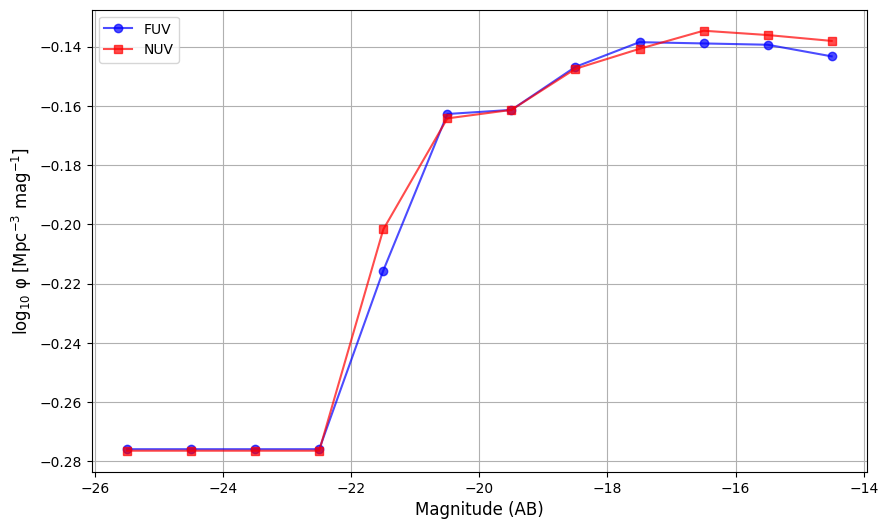

In [19]:
if colours:
    fig = plot_colour(x_train)
    plt.savefig('/disk/xray15/aem2/plots/28pams/IllustrisTNG/SB/test/colours_test/colour_check.png')
    plt.show()

if luminosity_functions:
    fig = plot_uvlf(x_train)
    plt.savefig('/disk/xray15/aem2/plots/28pams/IllustrisTNG/SB/test/LFs_test/uvlf_check.png')
    plt.show()


In [20]:
# After scaling, convert to torch tensors with correct dtype
x_train = torch.tensor(x_train, dtype=torch.float32, device=device) 
x_test = torch.tensor(x_test, dtype=torch.float32, device=device)
theta_train = torch.tensor(theta_train, dtype=torch.float32, device=device)
theta_test = torch.tensor(theta_test, dtype=torch.float32, device=device)

In [21]:
train_args = {
    "training_batch_size": 16,     # Slightly reduced
    "learning_rate": 1e-4,        # Original learning rate for fewer parameters
    "stop_after_epochs": 20,      # More patience
    "clip_max_norm": 2,        # Tight gradient control
     "validation_fraction": 0.1,    # More validation data
    "max_num_epochs": 200,       # Allow longer training
    "show_train_summary": True
}

# Slightly increased capacity for better learning of core parameters
hidden_features = 30
num_transforms = 2
num_nets = 1

# refer back to training args in file name
model_params = f"batch{train_args['training_batch_size']}_" \
               f"lr{train_args['learning_rate']:.0e}_" \
               f"epochs{train_args['stop_after_epochs']}_" \
               f"val{train_args['validation_fraction']}_" \
               f"hidden{hidden_features}_" \
               f"transforms{num_transforms}"

# Create neural networks
nets = [ili.utils.load_nde_sbi(
    engine="NPE",
    model="nsf",
    hidden_features=hidden_features,
    num_transforms=num_transforms,
) for _ in range(num_nets)]

# Modify loader to use core parameters
loader = NumpyLoader(
    x=x_train,
    theta=theta_train
)

# Update model output directory for phase 1
# model_out_dir_phase1 = os.path.join(model_out_dir, "phase1_core")
# os.makedirs(model_out_dir_phase1, exist_ok=True)

# Create inference runner with core parameters
runner = InferenceRunner.load(
    backend="sbi",
    engine="NPE",
    prior=prior,
    nets=nets,
    device=device,
    train_args=train_args,
    proposal=None,
    out_dir=model_out_dir,
    # name=name + "_phase1_core"
)



In [ ]:
# After training, update plotting to show only core parameters
posterior_ensemble, summaries = runner(loader=loader)


INFO:root:MODEL INFERENCE CLASS: NPE
/disk/xray15/aem2/envs/camels/lib/python3.8/site-packages/sbi/utils/torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect no significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(
INFO:root:Training model 1 / 1.


 Training neural network. Epochs trained: 14

In [ ]:
posterior_ensemble

In [ ]:
summaries

In [ ]:
def plot_training_diagnostics(summaries):
    """Plot training diagnostics without empty subplots"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))  # Changed to 1 row, 2 columns
    
    # Loss curves
    train_losses = summaries[0]['training_log_probs']
    val_losses = summaries[0]['validation_log_probs']
    epochs = range(len(train_losses))
    
    ax1.plot(epochs, train_losses, '-', label='Training', color='blue')
    ax1.plot(epochs, val_losses, '--', label='Validation', color='red')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Log probability')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Overfitting gap
    gap = np.array(train_losses) - np.array(val_losses)
    ax2.plot(epochs, gap, '-', color='purple')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss difference')
    ax2.set_title('Overfitting Gap')
    ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

# Use the function
fig = plot_training_diagnostics(summaries)
plt.savefig(os.path.join(plots_out_dir, f'loss_overfitting_{model_params}.png'))
plt.show()
plt.close()

In [ ]:
# plot train/validation loss
fig, ax = plt.subplots(1, 1, figsize=(6,4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

### Drawing samples from the entire test set to look at overall performance of the model

In [ ]:
type(theta_test)

In [ ]:
type(x_test)

In [31]:
# After scaling, convert to torch tensors with correct dtype
# x_train = torch.tensor(x_train, dtype=torch.float32, device=device) 
x_test = torch.tensor(x_test, dtype=torch.float32, device=device)
# theta_train = torch.tensor(theta_train, dtype=torch.float32, device=device)
theta_test = torch.tensor(theta_test, dtype=torch.float32, device=device)


In [ ]:
type(theta_test)

In [ ]:
type(x_test)

In [ ]:
# Number of samples to draw from posterior
n_samples = 1000

# Storage for predictions
all_samples = []
all_means = []
all_stds = []

# Suppress the deprecation warning
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='nflows.transforms.lu')

# # Ensure x_test is on the correct device
# if torch.is_tensor(x_test):
#     x_test = x_test.to(device)  # Move to whatever device we're using (CPU or CUDA)
# else:
#     x_test = torch.tensor(x_test, dtype=torch.float32, device=device)

# Generate posterior samples for each test point
for i in range(len(x_test)):
    # Get samples from the posterior
    with torch.no_grad():  # Disable gradient computation for efficiency
        # Ensure input is on the correct device and properly shaped
        x_i = x_test[i].reshape(1, -1)
        
        # Generate samples
        samples = posterior_ensemble.sample(
            (n_samples,), 
            x=x_i
        )
        
        # Move to CPU and convert to numpy only after all computations are done
        samples_np = samples.cpu().numpy()
    
    # Calculate statistics in numpy for efficiency
    mean = samples_np.mean(axis=0)
    std = samples_np.std(axis=0)
    
    # Store results
    all_samples.append(samples_np)
    all_means.append(mean)
    all_stds.append(std)

# Convert lists to numpy arrays
all_samples = np.array(all_samples)
all_means = np.array(all_means)
all_stds = np.array(all_stds)

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

fontsize = 10

for i, (param_name, ax) in enumerate(zip(param_names, axes)):
    # True vs predicted with error bars
    ax.errorbar(
        theta_test[:, i].cpu().numpy(),
        all_means[:, i],
        yerr=all_stds[:, i],
        fmt='.',
        color='k',
        ecolor='blue',
        capsize=0,
        elinewidth=0.8,  
        alpha=0.3,       
        markersize=5    
    )
    
    # Add true line
    lims = [
        min(theta_test[:, i].cpu().numpy().min(), all_means[:, i].min()),
        max(theta_test[:, i].cpu().numpy().max(), all_means[:, i].max())
    ]
    ax.plot(lims, lims, '--', color='black', alpha=0.5, linewidth=1)
    
    # Calculate metrics
    rmse = np.sqrt(np.mean((theta_test[:, i].cpu().numpy() - all_means[:, i])**2))
    r2 = np.corrcoef(theta_test[:, i].cpu().numpy(), all_means[:, i])[0, 1]**2
    chi2 = np.mean(((theta_test[:, i].cpu().numpy() - all_means[:, i])**2) / (all_stds[:, i]**2))
    
    # Add metrics box
    stats_text = f'RMSE = {rmse:.2f}\nR² = {r2:.2f}\nχ² = {chi2:.2f}'
    ax.text(0.05, 0.95, stats_text,
            transform=ax.transAxes,
            bbox=dict(facecolor='white', alpha=0.8),
            verticalalignment='top',
            fontsize=fontsize-1)
    
    ax.set_title(param_name, fontsize=fontsize)
    ax.set_xlabel('True', fontsize=fontsize-1)
    ax.set_ylabel('Inferred', fontsize=fontsize-1)
    ax.tick_params(labelsize=fontsize-2)
    ax.margins(x=0.05, y=0.05)

plt.tight_layout()
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
config_str = (f"batch{train_args['training_batch_size']}_"
             f"lr{train_args['learning_rate']}_"
             f"epochs{train_args['stop_after_epochs']}_"
             f"h{hidden_features}_t{num_transforms}")

# coverage plots
metric = PosteriorCoverage(
    num_samples=int(4e3),
    sample_method='direct',
    labels=cam.labels,
    plot_list=["tarp"], # "coverage", "histogram", "predictions", 
    out_dir=plots_out_dir,
)

# Generate plots
figs = metric(
    posterior=posterior_ensemble,
    x=x_test.cpu(),
    theta=theta_test.cpu(),
    signature=f"coverage_{name}_{config_str}_"  # Add config to filename
)

config_text = (
    f"Training Config:\n"
    f"Batch Size: {train_args['training_batch_size']}\n"
    f"Learning Rate: {train_args['learning_rate']}\n"
    f"Epochs: {train_args['stop_after_epochs']}\n"
    f"Hidden Features: {hidden_features}\n"
    f"Num Transforms: {num_transforms}"
)

# Process each figure
for i, fig in enumerate(figs):
    plt.figure(fig.number)  # Activate the figure
    plt.figtext(0.02, 0.98, config_text,
                fontsize=8,
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'),
                verticalalignment='top')
    
    # Save each figure with type indicator
    plot_types = ["tarp"] #"coverage", "histogram", "predictions",
    plt.savefig(os.path.join(plots_out_dir, 
                f'metric_{plot_types[i]}_{name}_{config_str}.png'), 
                dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

In [ ]:
def get_performance_metric(summaries, posterior):
    # Get validation loss at convergence
    final_val_loss = summaries[0]['validation_log_probs'][-1]
    
    # Get average RMSE across parameters
    rmse_vals = [
        np.sqrt(np.mean((theta_test[:, i].cpu().numpy() - all_means[:, i])**2))
        for i in range(len(param_names))
    ]
    avg_rmse = np.mean(rmse_vals)
    
    # Get average R² across parameters  
    r2_vals = [
        np.corrcoef(theta_test[:, i].cpu().numpy(), all_means[:, i])[0, 1]**2 
        for i in range(len(param_names))
    ]
    avg_r2 = np.mean(r2_vals)

    # Composite score (lower is better)
    # Weighting validation loss more heavily since it's key for convergence
    composite_score = -final_val_loss + avg_rmse - avg_r2

    return {
        'composite_score': composite_score,
        'val_loss': final_val_loss,
        'avg_rmse': avg_rmse,
        'avg_r2': avg_r2
    }

results = {
    'architecture': {
        'hidden_features': hidden_features,
        'num_transforms': num_transforms,
        'num_nets': num_nets
    },
    'training': {
        'batch_size': train_args['training_batch_size'],
        'learning_rate': train_args['learning_rate'],
        'epochs': train_args['stop_after_epochs']
    },
    'performance': get_performance_metric(summaries, posterior_ensemble)
}

# Flatten the nested dictionary into a single level
flat_results = {
   'hidden_features': results['architecture']['hidden_features'],
   'num_transforms': results['architecture']['num_transforms'], 
   'num_nets': results['architecture']['num_nets'],
   'batch_size': results['training']['batch_size'],
   'learning_rate': results['training']['learning_rate'],
   'epochs': results['training']['epochs'],
   'composite_score': results['performance']['composite_score'],
   'val_loss': results['performance']['val_loss'],
   'avg_rmse': results['performance']['avg_rmse'], 
   'avg_r2': results['performance']['avg_r2']
}

# Create DataFrame with single row
df = pd.DataFrame([flat_results])

# Improve formatting
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(df.to_string(index=False))

In [86]:
import os

def save_results(results):
   flat_results = {
       'hidden_features': results['architecture']['hidden_features'],
       'num_transforms': results['architecture']['num_transforms'], 
       'num_nets': results['architecture']['num_nets'],
       'batch_size': results['training']['batch_size'],
       'learning_rate': results['training']['learning_rate'],
       'epochs': results['training']['epochs'],
       'composite_score': results['performance']['composite_score'],
       'val_loss': results['performance']['val_loss'],
       'avg_rmse': results['performance']['avg_rmse'],
       'avg_r2': results['performance']['avg_r2']
   }
   
   df_row = pd.DataFrame([flat_results])
   
   if os.path.exists('sbi_results_norm.csv'):
       df_row.to_csv('sbi_results_norm.csv', mode='a', header=False, index=False)
   else:
       df_row.to_csv('sbi_results_norm.csv', index=False)
       
save_results(results)

The composite score weights validation loss more heavily since it's crucial for the model's predictive performance. Lower composite scores indicate better overall performance.